In [1]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from helpers import train, evaluation, generate_confusion_matrix
from helpers import plot_accuracy, plot_loss, plot_confusion_matrix

In [2]:
DATA_PATH = './15SceneData/'
MODELS_PATH = './models/'
PLOTS_PATH = './plots/'
SEMI_SUPERVISED_NAME = 'rotation_v1.pt'
MODEL_NAME = 'rotation_supervised'

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

NUM_CLASSES = 15
BATCH_SIZE = 32
NUM_EPOCHS = 100
PATIENCE = 30

In [3]:
# Load the dataset
# Use same transforms as in pretext-task 'rotation_classifiction_v1.ipynb'
train_dataset = datasets.ImageFolder(DATA_PATH + 'train',
                                     transform=transforms.Compose([
                                         transforms.Resize((224, 224)),
                                         transforms.RandomResizedCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                     ]))

val_dataset = datasets.ImageFolder(DATA_PATH + 'validation',
                                   transform=transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])
                                   ]))

In [4]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [5]:
model = torch.load(MODELS_PATH + SEMI_SUPERVISED_NAME, map_location=DEVICE)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable params before freezing feature extraction params: {:,}'.format(trainable).replace(',', ' '))

# Freeze the feature parameters
for feature_param in model.features.parameters():
    feature_param.requires_grad = False


# Change the last layer to output 15 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, NUM_CLASSES, bias=True),  # 60 / 59
)

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Trainable params after freezing feature extraction params: {:,}'.format(trainable).replace(',', ' '))

print(model.classifier)

Trainable params before freezing feature extraction params: 4 012 672
Trainable params after freezing feature extraction params: 19 215
Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=15, bias=True)
)


In [6]:
# Same settings as in the last model of fully-supervised training
optimizer = optim.Adam(params_to_update, lr=0.001)
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

model.to(DEVICE)


fitted, train_loss, train_acc, val_loss,  val_acc = train(
    model, 
    optimizer,
    loss_fn,
    train_loader, 
    val_loader, 
    lr_scheduler=lr_scheduler,
    num_epochs=NUM_EPOCHS, 
    patience=PATIENCE, 
    device=DEVICE
    )

torch.save(fitted, MODELS_PATH + MODEL_NAME + '.pt')

Epoch [100/100]: 100%|██████████| 47/47 [00:06<00:00,  7.61it/s, train_acc=57.7, train_loss=1.24, val_acc=66.1, val_loss=0.993]


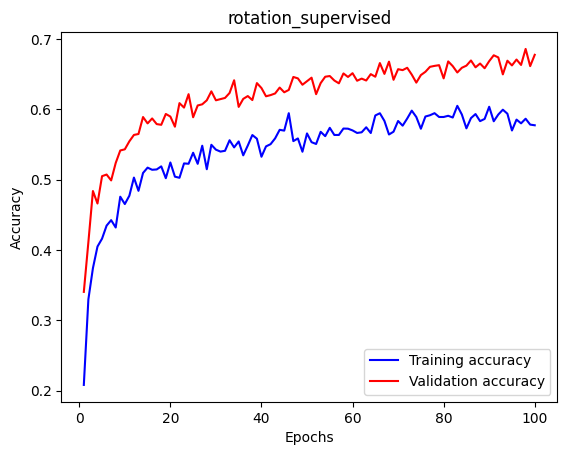

In [7]:
plot_accuracy(train_acc, val_acc, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_accuracy.png')

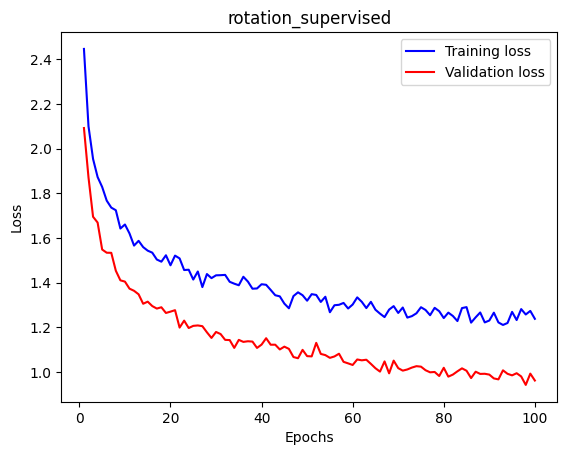

In [8]:
plot_loss(train_loss, val_loss, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_loss.png')

In [9]:
_, train_accuracy = evaluation(fitted, train_loader, nn.CrossEntropyLoss(), DEVICE)
_, val_accuracy = evaluation(fitted, val_loader, nn.CrossEntropyLoss(), DEVICE)

print(f'Train accuracy: {train_accuracy*100.:.2f}%')
print(f'Validation accuracy: {val_accuracy*100.:.2f}%')

Train accuracy: 66.33%
Validation accuracy: 68.58%


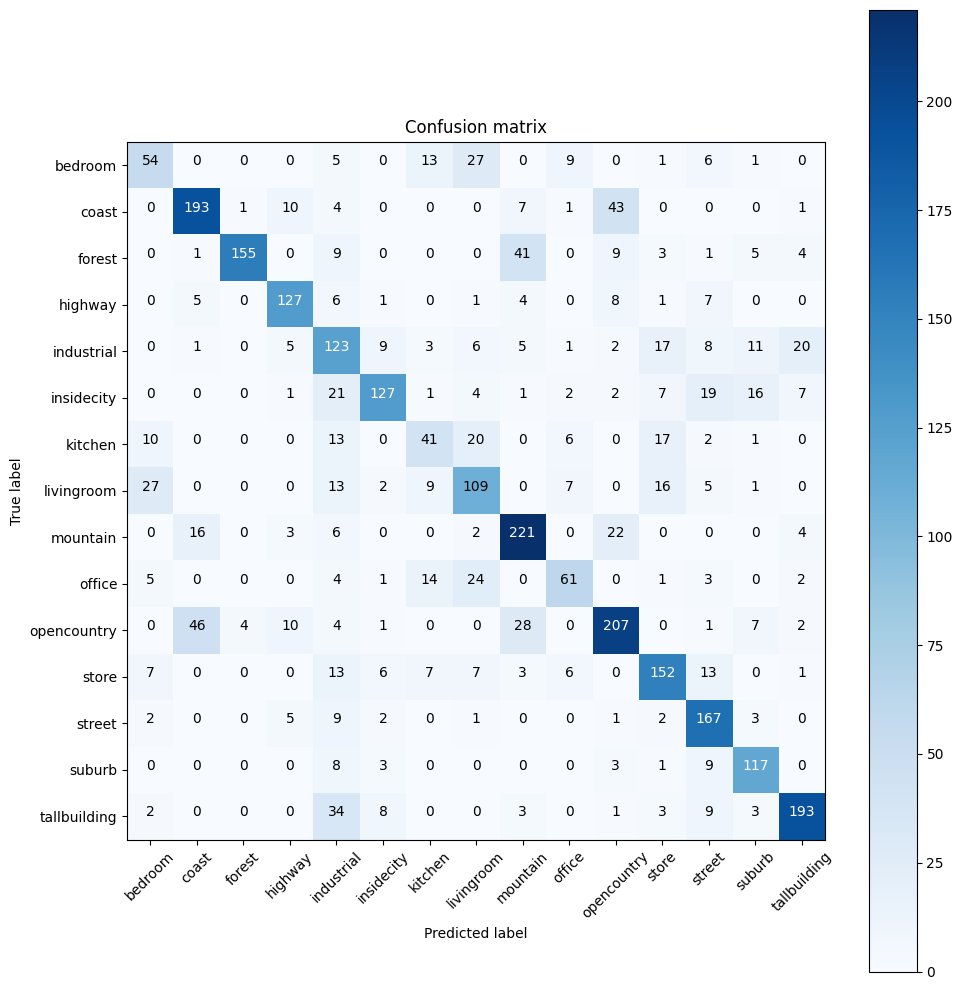

In [10]:
cm = generate_confusion_matrix(fitted, val_loader, DEVICE)

plot_confusion_matrix(
    cm,
    val_loader.dataset.classes,
    'Confusion matrix',
    PLOTS_PATH + MODEL_NAME + '_confusion_matrix.png',
    normalize=False
)